In [29]:
# Enhanced Comparison Analysis - Checkout Visits, Pop-up Modal, and Purchase Events
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

# Load the CSV file
df = pd.read_csv('analytics.csv')

# Convert created_at to datetime
df['created_at'] = pd.to_datetime(df['created_at'], format='mixed', errors='coerce')
df['date'] = df['created_at'].dt.date

# === 1. ADD-TO-CART EVENTS (from original analysis) ===
add_to_cart_df = df[df['type'] == 'add-to-cart'].copy()
add_to_cart_per_site = add_to_cart_df.groupby('domain').size().reset_index(name='cart_count')
add_to_cart_per_site = add_to_cart_per_site.sort_values('cart_count', ascending=False)
top10_cart_sites = add_to_cart_per_site.head(10).copy()

# === 2. CHECKOUT PAGE VISITS ===
# Filter for URLs containing "/checkout"
checkout_df = df[df['url'].str.contains('/checkout|/cart|/shoppingcart|/bag', case=False, na=False)].copy()
print(f"Total checkout page visits: {len(checkout_df)}")

# Count unique sessions with checkout page visits
checkout_sessions = checkout_df['session_id'].nunique()
print(f"Number of sessions with checkout page visits: {checkout_sessions}")

# Only count one checkout event per session_id per domain
checkout_per_site = checkout_df.drop_duplicates(subset=['domain', 'session_id']).groupby('domain').size().reset_index(name='checkout_count')
checkout_per_site = checkout_per_site.sort_values('checkout_count', ascending=False)
top_checkout_sites = checkout_per_site.head(10)

print("\nTop websites by checkout visits:")
print(top_checkout_sites)

# === 3. ANTI-IMPULSE MODAL DISPLAY ===
# Filter for enforce_wait_modal_shown events
modal_df = df[df['type'] == 'enforce_wait_modal_shown'].copy()
print(f"\nTotal anti-impulse modal displays: {len(modal_df)}")

# Count unique sessions where modal was shown
modal_sessions = modal_df['session_id'].nunique()
print(f"Number of sessions where anti-impulse modal was shown: {modal_sessions}")

# Count modal displays per website
modal_per_site = modal_df.groupby('domain').size().reset_index(name='modal_count')
modal_per_site = modal_per_site.sort_values('modal_count', ascending=False)
top_modal_sites = modal_per_site.head(10)

# Count page-views

page_views_per_site = df[df["type"] == 'page-view'].groupby('domain').size().reset_index(name='page_views')

print("\nTop websites by modal displays:")
print(top_modal_sites)

# === 4. PURCHASE / PLACE-ORDER EVENTS ===
# Filter for place-order events
purchase_df = df[df['type'] == 'place-order'].copy()
print(f"\nTotal purchase/place-order events: {len(purchase_df)}")

# Count unique sessions with purchases
purchase_sessions = purchase_df['session_id'].nunique()
print(f"Number of sessions with completed purchases: {purchase_sessions}")

# Count purchases per website
purchase_per_site = purchase_df.groupby('domain').size().reset_index(name='purchase_count')
purchase_per_site = purchase_per_site.sort_values('purchase_count', ascending=False)
top_purchase_sites = purchase_per_site.head(10)

print("\nTop websites by purchases:")
print(top_purchase_sites)

Total checkout page visits: 729
Number of sessions with checkout page visits: 22

Top websites by checkout visits:
             domain  checkout_count
9          shop.app               5
1        amazon.com               4
5          etsy.com               2
10  ticketmaster.dk               2
0      amazon.co.uk               1
2         apple.com               1
3          asos.com               1
4    billetlugen.dk               1
6      greenmind.dk               1
7            hm.com               1

Total anti-impulse modal displays: 14
Number of sessions where anti-impulse modal was shown: 7

Top websites by modal displays:
          domain  modal_count
3       shop.app            6
4  walgreens.com            3
2       ikea.com            2
0      apple.com            1
1       etsy.com            1
5       zara.com            1

Total purchase/place-order events: 0
Number of sessions with completed purchases: 0

Top websites by purchases:
Empty DataFrame
Columns: [domain, pur

In [30]:
# === 5. TIME SPENT DATA (for comparison) ===
# Filter to include only time-spent events
time_spent_df = df[df['type'] == 'time-spent'].copy()
colors = ['salmon', '#F899F3', '#73FABD', '#6ED1F8','#E0F26D',  '#106ED3']

# Extract duration from payload (convert from milliseconds to minutes)
def extract_duration(payload):
    try:
        data = json.loads(payload)
        duration_ms = data.get('duration', 0)
        return duration_ms / 60000  # Convert ms to minutes
    except (json.JSONDecodeError, TypeError):
        return 0

time_spent_df['duration_minutes'] = time_spent_df['payload'].apply(extract_duration)
website_time_spent = time_spent_df.groupby('domain')['duration_minutes'].sum().reset_index()
website_time_spent = website_time_spent.sort_values('duration_minutes', ascending=False)
top_time_sites = website_time_spent.head(10)

# === 6. COMBINED ANALYSIS ===
# Create a list of all domains that appear in any of our top lists
all_domains = set(list(top10_cart_sites['domain']) + 
                  list(top_checkout_sites['domain']) + 
                  list(top_modal_sites['domain']) + 
                  list(top_purchase_sites['domain']))

# Create a comprehensive dataframe with all metrics
combined_df = pd.DataFrame({'domain': list(all_domains)})

# Merge with each individual metric
combined_df = pd.merge(combined_df, add_to_cart_per_site[['domain', 'cart_count']], on='domain', how='left')
combined_df = pd.merge(combined_df, checkout_per_site[['domain', 'checkout_count']], on='domain', how='left')
combined_df = pd.merge(combined_df, modal_per_site[['domain', 'modal_count']], on='domain', how='left')
combined_df = pd.merge(combined_df, website_time_spent[['domain', 'duration_minutes']], on='domain', how='left')
combined_df = pd.merge(combined_df, page_views_per_site[['domain', 'page_views']], on='domain', how='left')

# Fill NaN values with 0
combined_df = combined_df.fillna(0)

# Sort by cart_count to maintain the same order as the original analysis
combined_df = combined_df.sort_values('page_views', ascending=False)
combined_df = combined_df[~combined_df["domain"].isin(['shop.app', 'ticketmaster.dk', 'billetlugen.dk'])]
combined10_df = combined_df.head(10).copy()  # Take top 10 by add-to-cart events

# === 7. CREATE ENHANCED COMPARISON VISUALIZATION ===
plt.figure(figsize=(7, 6))

# Convert seconds to minutes for more intuitive comparison
combined10_df['time_spent_minutes'] = combined10_df['duration_minutes']

# Normalize the values for visualization (similar to the original comparison)
total_values = {
    'cart_count': combined10_df['cart_count'].sum(),
    'checkout_count': combined10_df['checkout_count'].sum() if combined10_df['checkout_count'].sum() > 0 else 1,
    'modal_count': combined10_df['modal_count'].sum() if combined10_df['modal_count'].sum() > 0 else 1,
    'time_spent_minutes': combined10_df['time_spent_minutes'].sum() if combined10_df['time_spent_minutes'].sum() > 0 else 1,
    'page_views': combined10_df['page_views'].sum() if combined10_df['page_views'].sum() > 0 else 1
}

# Create normalized columns for plotting (normalized by total sum)
for col, total_val in total_values.items():
    combined10_df[f'{col}_norm'] = combined10_df[col] / total_val

# Set up the plot
domains = combined10_df['domain']
y = np.arange(len(domains))
bar_width = 0.2
colors = ['salmon', '#F899F3', '#73FABD', '#6ED1F8','#E0F26D', '#106ED3']

# Plot the bars with different colors
plt.barh(y + bar_width*1.5, combined10_df['page_views_norm'], bar_width,
        label=f'Page visits (max={int(total_values["page_views"])})', color=colors[5], zorder=2)

plt.barh(y + bar_width * 0.5, combined10_df['checkout_count_norm'], bar_width,
        label=f'Checkout Visits (max={int(total_values["checkout_count"])})', color=colors[1], zorder=2)

plt.barh(y - bar_width*0.5, combined10_df['modal_count_norm'], bar_width,
        label=f'Anti-Impulse Modal Shown (max={int(total_values["modal_count"])})', color=colors[3], zorder=2

plt.barh(y - bar_width*1.5, combined10_df['cart_count_norm'], bar_width, 
        label=f'Add-to-Cart Events (max={int(total_values["cart_count"])})', color=colors[0], zorder=2)

ax = plt.gca()
ax.grid(color='white', linewidth=1, axis='y', alpha=1, zorder=1)
ax.grid(color='white', linewidth=1, axis='x', alpha=1, zorder=1)
ax.set_facecolor('#F5F5F5')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.xlabel('Distribution of events', fontsize=12)
ax.set_xlim(0, 0.38)
ax.set_xticklabels(['{:.0f}%'.format(x*100) for x in ax.get_xticks()])
plt.title('Shopping behaviour on most visited websites', fontweight='bold')
plt.yticks(y, domains, rotation=45, ha='right', fontsize=12)
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig('./plots/shopping-behaviour.png', dpi=300, bbox_inches='tight')
plt.show()

SyntaxError: '(' was never closed (2191683776.py, line 77)

/var/folders/yv/xt28csc14lq6qntd89nbqmfm0000gn/T/ipykernel_52737/3646353879.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:.0f}%'.format(x*100) for x in ax.get_xticks()])


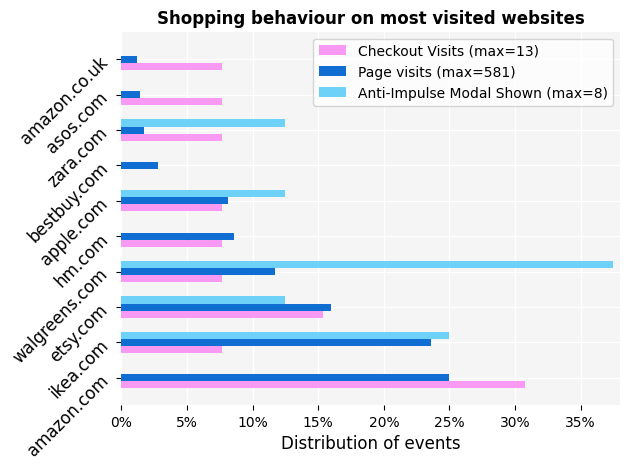

In [31]:

# Set up the plot
domains = combined10_df['domain']
y = np.arange(len(domains))
bar_width = 0.2
colors = ['salmon', '#F899F3', '#73FABD', '#6ED1F8','#E0F26D', '#106ED3']

# Plot the bars with different colors
plt.barh(y - bar_width, combined10_df['checkout_count_norm'], bar_width,
        label=f'Checkout Visits (max={int(total_values["checkout_count"])})', color=colors[1], zorder=2)

plt.barh(y, combined10_df['page_views_norm'], bar_width,
        label=f'Page visits (max={int(total_values["page_views"])})', color=colors[5], zorder=2)

plt.barh(y + bar_width, combined10_df['modal_count_norm'], bar_width,
        label=f'Anti-Impulse Modal Shown (max={int(total_values["modal_count"])})', color=colors[3], zorder=2)

ax = plt.gca()
ax.grid(color='white', linewidth=1, axis='y', alpha=1, zorder=1)
ax.grid(color='white', linewidth=1, axis='x', alpha=1, zorder=1)
ax.set_facecolor('#F5F5F5')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.xlabel('Distribution of events', fontsize=12)
ax.set_xlim(0, 0.38)
ax.set_xticklabels(['{:.0f}%'.format(x*100) for x in ax.get_xticks()])
plt.title('Shopping behaviour on most visited websites', fontweight='bold')
plt.yticks(y, domains, rotation=45, ha='right', fontsize=12)
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig('./plots/shopping-behaviour.png', dpi=300, bbox_inches='tight')
plt.show()

len 11
Ratios of checkout visits and modal shown to page visits:
           domain  page_views  checkout_count  modal_count  \
10     amazon.com         145             4.0          0.0   
8        ikea.com         137             1.0          2.0   
6        etsy.com          93             2.0          1.0   
1   walgreens.com          68             1.0          3.0   
11         hm.com          50             1.0          0.0   
0       apple.com          47             1.0          1.0   
4     bestbuy.com          16             0.0          0.0   
7        zara.com          10             1.0          1.0   
13       asos.com           8             1.0          0.0   
5    amazon.co.uk           7             1.0          0.0   
3    greenmind.dk           2             1.0          0.0   

    checkout_page_ratio  modal_page_ratio  
10             2.758621          0.000000  
8              0.729927          1.459854  
6              2.150538          1.075269  
1             

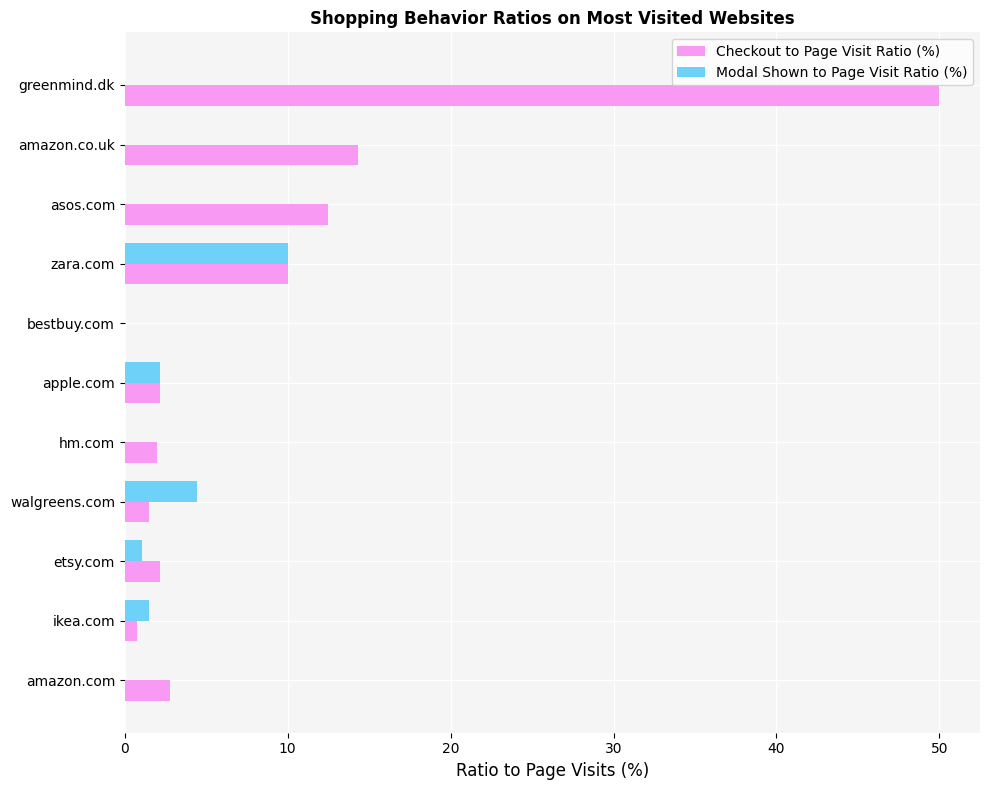

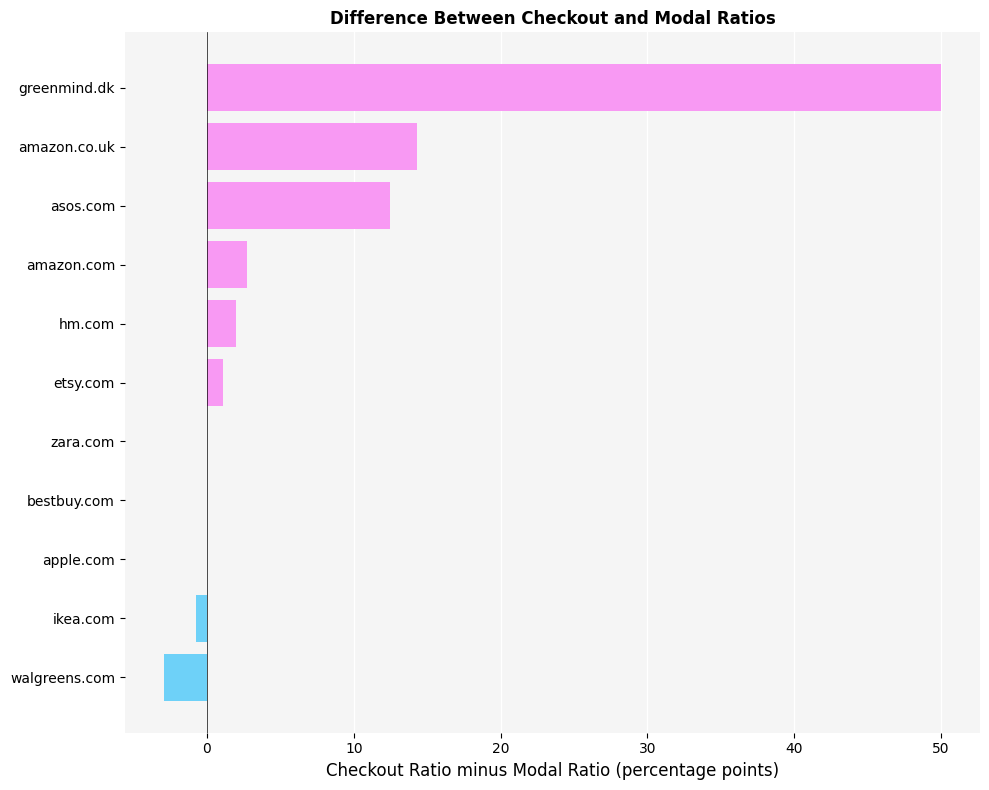

In [ ]:
# Create a new dataframe with the ratios between page visits, checkout visits, and modal shown
ratio_df = combined_df.copy()
print("len",len(ratio_df))

# Calculate the ratios
ratio_df['checkout_page_ratio'] = ratio_df['checkout_count'] / ratio_df['page_views'] * 100
ratio_df['modal_page_ratio'] = ratio_df['modal_count'] / ratio_df['page_views'] * 100

# Sort by page_views to show the most visited sites first
ratio_df = ratio_df.sort_values('page_views', ascending=False)

# Display the calculated ratios
print("Ratios of checkout visits and modal shown to page visits:")
print(ratio_df[['domain', 'page_views', 'checkout_count', 'modal_count', 'checkout_page_ratio', 'modal_page_ratio']])

# Create a visualization for the ratios
fig, ax = plt.figure(figsize=(10, 8)), plt.gca()

# Set up the plot data
domains = ratio_df['domain']
y = np.arange(len(domains))
bar_width = 0.35

# Create a plot showing both ratios side by side
plt.barh(y - bar_width/2, ratio_df['checkout_page_ratio'], bar_width, 
        label='Checkout to Page Visit Ratio (%)', color='#F899F3', zorder=2)
plt.barh(y + bar_width/2, ratio_df['modal_page_ratio'], bar_width, 
        label='Modal Shown to Page Visit Ratio (%)', color='#6ED1F8', zorder=2)

# Set up the plot styling
ax.grid(color='white', linewidth=1, axis='y', alpha=1, zorder=1)
ax.grid(color='white', linewidth=1, axis='x', alpha=1, zorder=1)
ax.set_facecolor('#F5F5F5')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add labels and title
plt.xlabel('Ratio to Page Visits (%)', fontsize=12)
plt.title('Shopping Behavior Ratios on Most Visited Websites', fontweight='bold')
plt.yticks(y, domains, rotation=0, ha='right', fontsize=10)
plt.legend(loc='upper right')
plt.tight_layout()

# Save and display the plot
plt.savefig('./plots/shopping-behavior-ratios.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a second visualization focusing on the relationship between the ratios
fig, ax = plt.figure(figsize=(10, 8)), plt.gca()

# Calculate the difference between ratios to show relative engagement patterns
ratio_df['ratio_difference'] = ratio_df['checkout_page_ratio'] - ratio_df['modal_page_ratio']

# Sort by the difference to highlight sites with most extreme behaviors
ratio_df_sorted = ratio_df.sort_values('ratio_difference')

# Plot the differences
plt.barh(np.arange(len(ratio_df_sorted)), ratio_df_sorted['ratio_difference'], color=np.where(ratio_df_sorted['ratio_difference'] > 0, '#F899F3', '#6ED1F8'), zorder=2)

# Set up the plot styling
ax.grid(color='white', linewidth=1, axis='x', alpha=1, zorder=1)
ax.set_facecolor('#F5F5F5')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# Add labels and title
plt.xlabel('Checkout Ratio minus Modal Ratio (percentage points)', fontsize=12)
plt.title('Difference Between Checkout and Modal Ratios', fontweight='bold')
plt.yticks(np.arange(len(ratio_df_sorted)), ratio_df_sorted['domain'], fontsize=10)
plt.tight_layout()

# Save and display the plot
#plt.savefig('./plots/ratio-difference.png', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
len(combined_df)

11